## Lab 3: Anomaly Detection 1

In this lab, you will be working with detecting anomalies in data. You will use basic Python libraries and the PyOD (https://pyod.readthedocs.io/en/latest/) library for detecting anomalies. Save your implementations with the name 'lab2_yourname.ipynb' and submit by the due date.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns",100)
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print
#Lab written in collaboration with Julia Anderberg

## Data overview

This dataset contains information on variants of the French wine. The dataset contains information on physicochemical variables that were recorded on different wine samples.

There 6497 datapoints and twelve variables, namely: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol level and quality.


In [7]:
wine_data= pd.read_excel('wine_data.xls')
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [8]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


Lets engineer a new feature 'score' that assigns values to the wine samples based on the quality.

In [9]:
#New feature
wine_data['score'] = [1 if x >= 5 else 0 for x in wine_data['quality']]


In [10]:
#For simplicity, we will now filter the dataset to a few features
wine_filtered=wine_data[['fixed acidity','volatile acidity', 'score']]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Data visualization as a tool for anomaly detection

</div>

The simplest way to detect any anomalies or outliers in your dataset is to plot the data to identify any outlier patterns. 
In the example below, we implement a boxplot on feature: fixed acidity and a histogram on feature: volatile acidity to check for outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x2a9ea330c70>,
 'caps': [<matplotlib.lines.Line2D at 0x2a9ea3312d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a9ea2f77f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a9ea3317b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a9ea331a80>],
 'means': []}

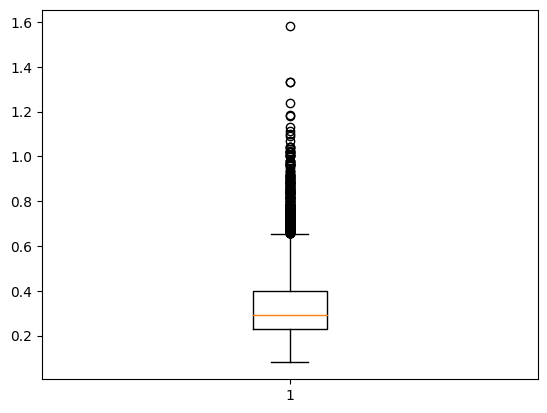

In [11]:
plt.boxplot(wine_filtered['volatile acidity'])

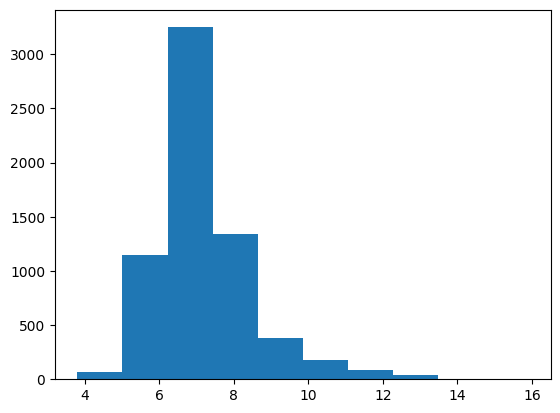

In [12]:
plt.hist(wine_filtered['fixed acidity'])
hist, bin_edges=np.histogram(wine_filtered['fixed acidity'].to_numpy(), density=False, bins=2)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### PyOD for anomaly detection

</div>


## Data Preparation


In [13]:
#we will use the 'score' as the labels and assign 'fixed acidity' and 'volatile acidity' as the features
labels=wine_filtered['score']
data=wine_filtered[['fixed acidity','volatile acidity']]

In [14]:
#we will use the standardizer from the PyOD library
from pyod.utils.utility import standardizer
data_std=standardizer(data)

In [15]:
#split percentage
split = int(0.7 * len(data))

train_data = data_std[:split]
test_data= data_std[split:]
train_labels= labels[:split]
test_labels=labels[split:]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Multivariate Methods

</div>

## HBOS

The idea behind HBOS is to construct a histogram of the data for each dimension and calculate a score for how likely it is for a datapoint to fall within the histogram bins for each dimension. 

It is important to note that HBOS from PyOD is sensitive to the number of bins selected for the histograms.In the example below, we implement HBOS on our data with the number of bins set to 3 and observe the results.


On Training Data:
HBOS ROC:0.3953, precision @ rank n:0.9343

On Test Data:
HBOS ROC:0.3606, precision @ rank n:0.7949


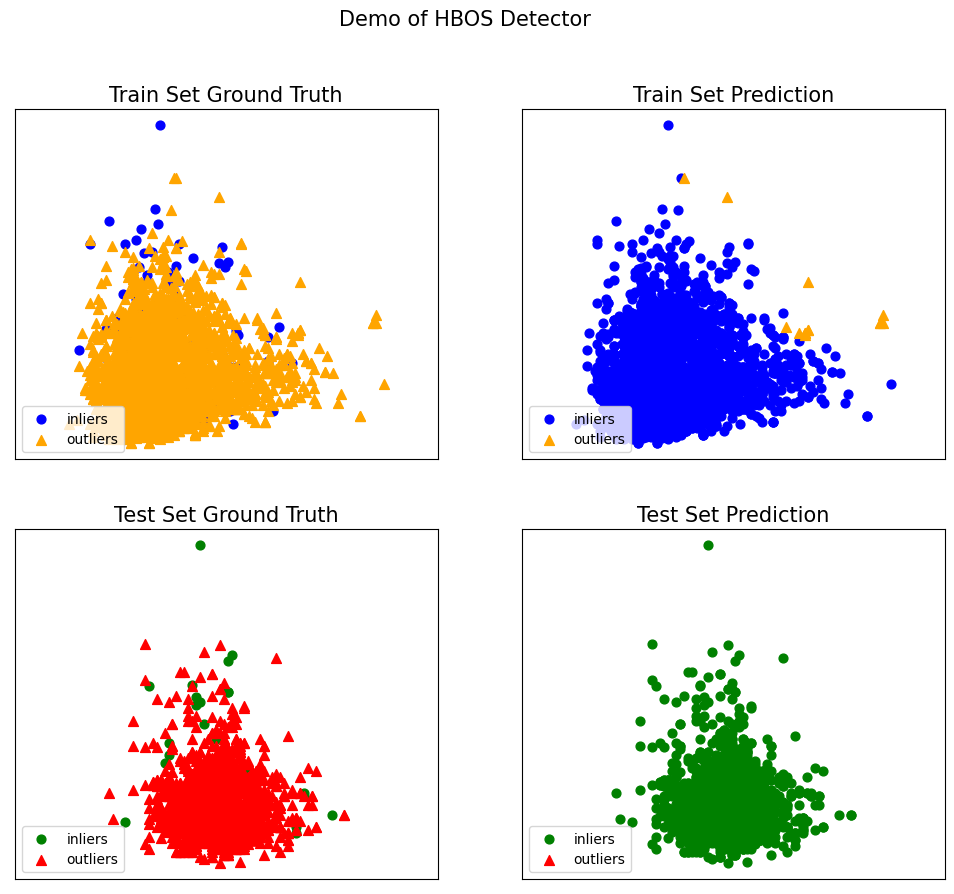

In [16]:
from pyod.models.hbos import HBOS


clf_hb=HBOS(n_bins=3, contamination=0.0367)
clf_hb.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_hb = clf_hb.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('HBOS', train_labels, train_scores_hb)
print("\nOn Test Data:")
evaluate_print('HBOS', test_labels, test_scores_hb)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)



<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 1

### Experiment with different values for the number of bins to see if you can increase the ROC score >= 0.75. 


</div>


On Training Data:
HBOS ROC:0.4169, precision @ rank n:0.9572

On Test Data:
HBOS ROC:0.3707, precision @ rank n:0.9728


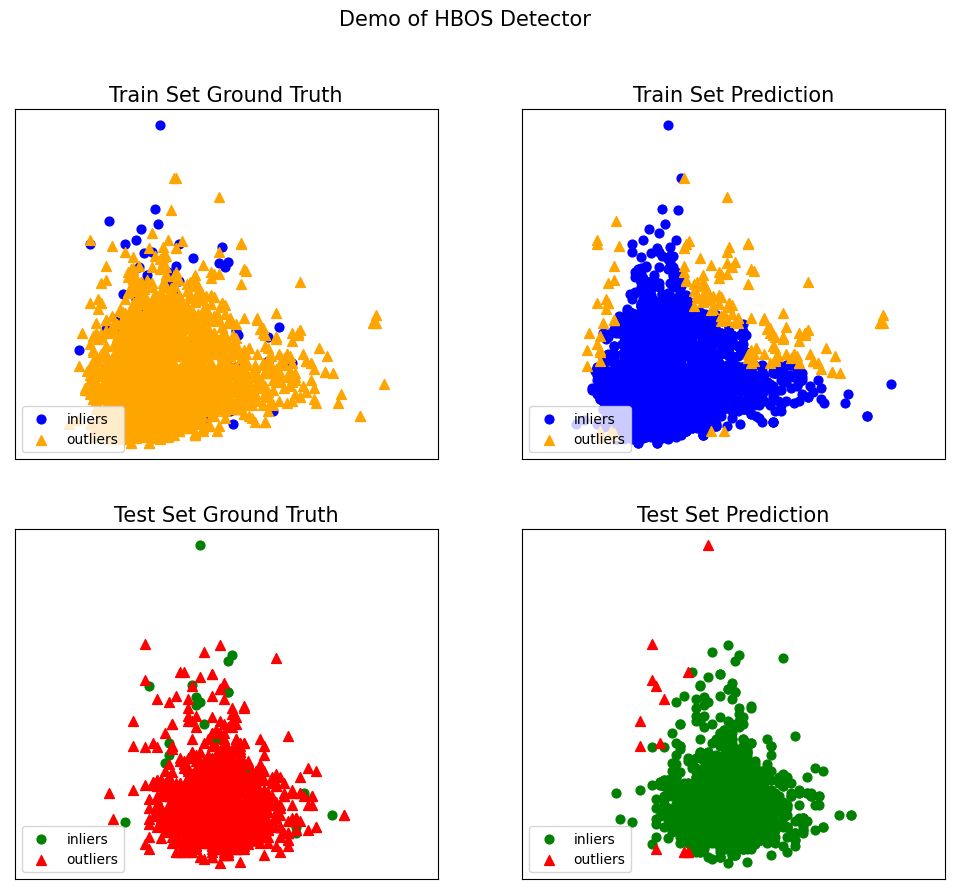

In [17]:
#Please implement Task 1 here
clf_hb=HBOS(n_bins=24, contamination=0.0367)
clf_hb.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_hb = clf_hb.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('HBOS', train_labels, train_scores_hb)
print("\nOn Test Data:")
evaluate_print('HBOS', test_labels, test_scores_hb)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)



<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Neighbourhood-based Methods

</div>

Neighbourhood based methods try to detect various types of multivariate outliers by considering neighbourhoods of datapoints.

## KNN

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 2

### Implement KNN with the pyod library. Use the Euclidean distance as the metric, and the average distance of the neighbours. Experiment with different values for n_neighbours. 

### Hint: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn



</div>


On Training Data:
KNN ROC:0.3709, precision @ rank n:0.9561

On Test Data:
KNN ROC:0.3649, precision @ rank n:0.9731


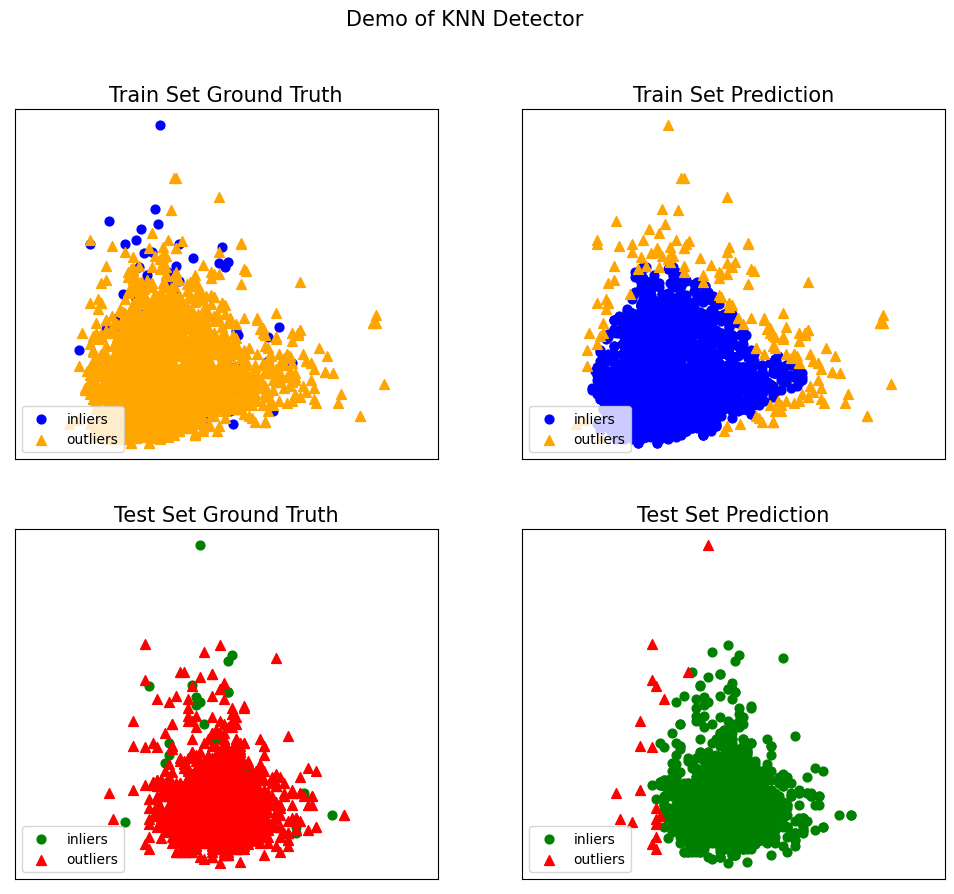

In [48]:
#Please implement Task 2 here
from pyod.models.knn import KNN

clf_knn=KNN(n_neighbors=40, contamination=0.0367, method='mean', metric='euclidean')
clf_knn.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_knn = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_knn = clf_knn.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_knn = clf_knn.predict(test_data)  # outlier labels (0 or 1)
test_scores_knn = clf_knn.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('KNN', train_labels, train_scores_knn)
print("\nOn Test Data:")
evaluate_print('KNN', test_labels, test_scores_knn)

visualize('KNN', train_data, train_labels, test_data, test_labels, train_pred_knn, test_pred_knn, show_figure=True, save_figure=False)



## LOF or COF

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 3

### Take a look at the scatterplot of the dataset with our two feature fixed acidity and volatile acidity. Determine whether we should use LOF or COF on the dataset and implement it. Give a reason for your choice?


### Hint: Use functions from the PyOD library



</div>

<img src="images/scatter.png" alt="Alternative text" />

C:\Users\ernil\AppData\Local\Programs\Python\Python310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\ernil\AppData\Local\Programs\Python\Python310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\ernil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ernil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)



On Training Data:
COF ROC:0.4108, precision @ rank n:0.946

On Test Data:
COF ROC:0.3378, precision @ rank n:0.9563


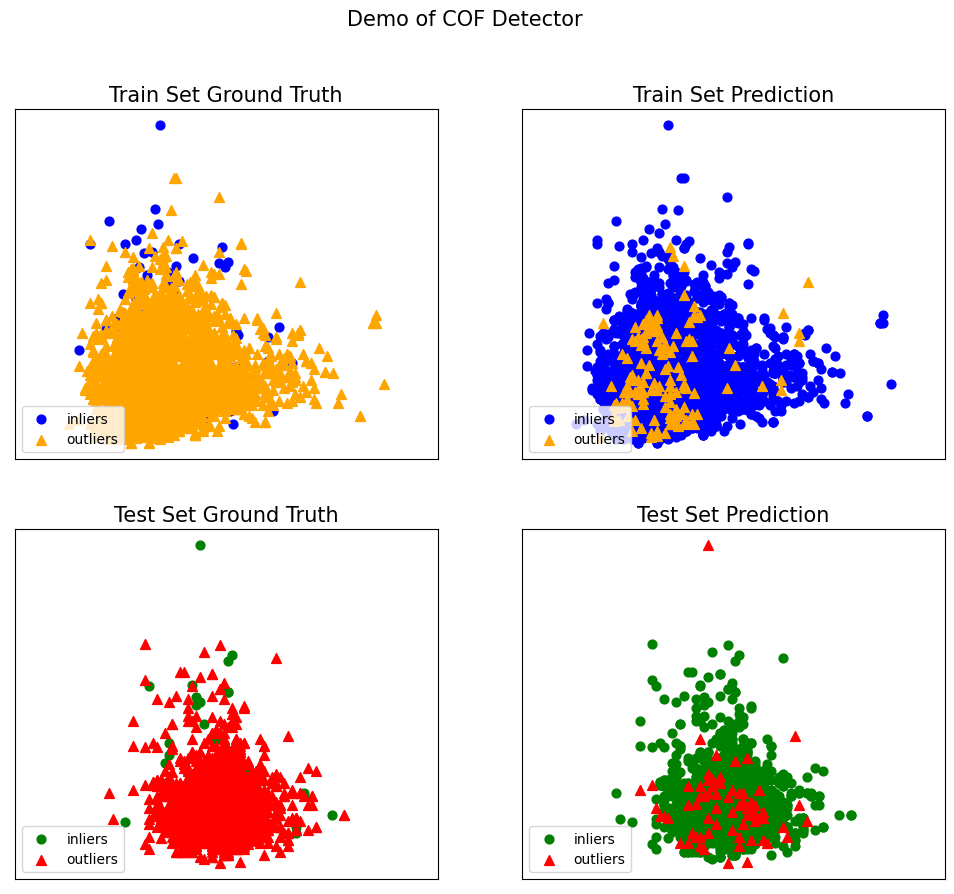

In [23]:
#Please implement Task 3 here
from pyod.models.cof import COF
from pyod.models.lof import LOF

clf_cof = COF(n_neighbors=3, contamination=0.0367)
clf_cof.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_cof = clf_cof.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_cof = clf_cof.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_cof = clf_cof.predict(test_data)  # outlier labels (0 or 1)
test_scores_cof = clf_cof.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('COF', train_labels, train_scores_cof)
print("\nOn Test Data:")
evaluate_print('COF', test_labels, test_scores_cof)

visualize('COF', train_data, train_labels, test_data, test_labels, train_pred_cof, test_pred_cof, show_figure=True, save_figure=False)

#COF was chosen since it is more versitile than LOF and can distinguish low density from outliers 

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### One-class classification based Methods

</div>

One-class classification based methods detect anomalies by finding a region of space where the majority of data samples reside with the highest density.

## One-class SVM

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 4

### Implement OCSVM with a linear or non-linear kernel of your choice.

   
### Hint: Use functions from the PyOD library https://pyod.readthedocs.io/en/latest/_modules/pyod/models/ocsvm.html



</div>


On Training Data:
OCSVM ROC:0.4094, precision @ rank n:0.957

On Test Data:
OCSVM ROC:0.3984, precision @ rank n:0.9731


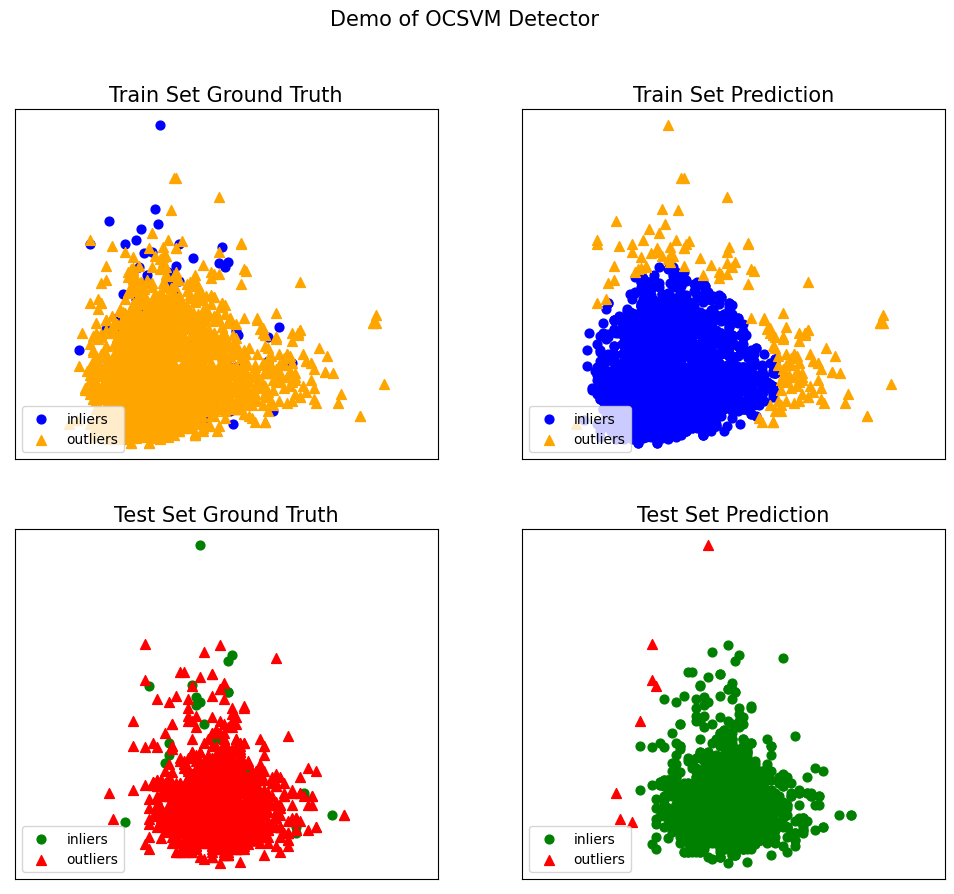

In [25]:
#Please implement Task 4 here
from pyod.models.ocsvm import OCSVM

clf_ocsvm=OCSVM(kernel='rbf', contamination=0.0367)
clf_ocsvm.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_ocsvm = clf_ocsvm.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_ocsvm = clf_ocsvm.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_ocsvm = clf_ocsvm.predict(test_data)  # outlier labels (0 or 1)
test_scores_ocsvm = clf_ocsvm.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('OCSVM', train_labels, train_scores_ocsvm)
print("\nOn Test Data:")
evaluate_print('OCSVM', test_labels, test_scores_ocsvm)

visualize('OCSVM', train_data, train_labels, test_data, test_labels, train_pred_ocsvm, test_pred_ocsvm, show_figure=True, save_figure=False)



<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Clustering-based Methods

</div>

Clustering-based approaches assume that normal data belongs to large and dense clusters while, anomalies either do not belong to any of the clusters or form very small clusters.

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 5

### Implement DBSCAN on the dataset. Experiment with 2 different values for epsilon and minpts. Report your results below. Which hyperparameter values give you better results??


Please note that we will use the sklearn version (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

</div>

27


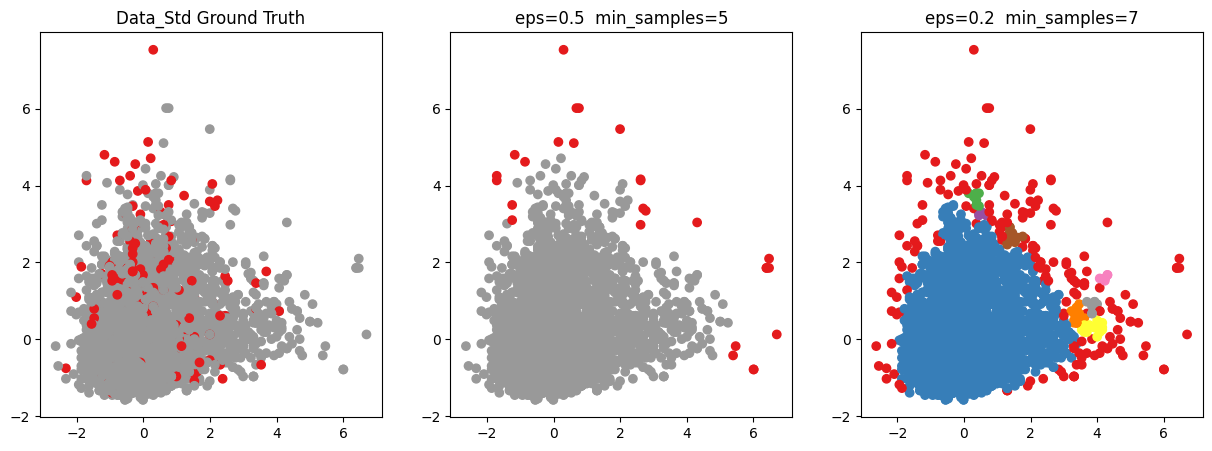

In [39]:
#Please implement Task 5 here
from sklearn.cluster import DBSCAN
import numpy as np
clf_dbscan_1 = DBSCAN(eps=0.5, min_samples=5)
clf_dbscan_1.fit(data_std)

clf_dbscan_2 = DBSCAN(eps=0.2, min_samples=7)
clf_dbscan_2.fit(data_std)

labels_1 = clf_dbscan_1.labels_
labels_2 = clf_dbscan_2.labels_
print(np.count_nonzero(labels_1))

data_x = data_std[:,0]
data_y = data_std[:,1]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(data_x, data_y, c=labels, cmap='Set1')
ax[0].set_title('Data_Std Ground Truth')

ax[1].scatter(data_x, data_y, c=labels_1, cmap='Set1')
ax[1].set_title('eps=0.5  min_samples=5')

ax[2].scatter(data_x, data_y, c=labels_2, cmap='Set1')
ax[2].set_title('eps=0.2  min_samples=7')

plt.show()
#The setting of eps=0.2 and min_samples appear to give better results altough perhaps creating some extra groups of outliers

<div class='alert alert-block alert-success' style="font-weight:bolder">
    
### Task 6

### Compare the results from HBOS, One-class SVM, LOF or COF and KNN. Which one performed better? Can you think of any reasons why?.
    
</div>

### Write your answer to task 6 here.

One-class SVM appear to separate the training set into inliers and outliers better, knn could give a good separation aswell with a high enough k. Support vector machine classifiers are very good at separating datasets that can be modeled linearly, polynomially or using some other model.